<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

# Comprehensive Trading System Analysis

This notebook provides complete analysis of the full trading system including signals, portfolio, and execution.

**Key Features:**
- Signal generation analysis
- Trade execution analysis
- Portfolio performance metrics
- Risk analysis
- Execution cost analysis
- Position and fill analysis

In [1]:
# Parameters will be injected here by papermill
# This cell is tagged with 'parameters' for papermill to recognize it
run_dir = "."
config_name = "config"
symbols = ["SPY"]
timeframe = "5m"

# Analysis parameters
execution_cost_bps = 1.0  # Round-trip execution cost in basis points
analyze_slippage = True
analyze_intraday_patterns = True
market_timezone = "America/New_York"

# Performance thresholds
min_sharpe_ratio = 1.0
max_acceptable_drawdown = 0.20  # 20%
min_win_rate = 0.45

In [2]:
# Parameters
run_dir = "/Users/daws/ADMF-PC/config/bollinger/results/20250703_203435"
config_name = "bollinger"
symbols = ["SPY"]
timeframe = "5m"


## Setup

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime, time
import pytz
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Convert run_dir to Path
run_dir = Path(run_dir).resolve()
print(f"Analyzing run: {run_dir.name}")
print(f"Full path: {run_dir}")
print(f"Config: {config_name}")
print(f"Symbol(s): {symbols}")
print(f"Timeframe: {timeframe}")

Analyzing run: 20250703_203435
Full path: /Users/daws/ADMF-PC/config/bollinger/results/20250703_203435
Config: bollinger
Symbol(s): ['SPY']
Timeframe: 5m


## Load Metadata and Traces

In [4]:
# Load run metadata
metadata_path = run_dir / 'metadata.json'
if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    print(f"✅ Run metadata loaded")
    print(f"   Total bars: {metadata.get('total_bars', 'N/A')}")
    print(f"   Total signals: {metadata.get('total_signals', 'N/A')}")
    print(f"   Total orders: {metadata.get('total_orders', 'N/A')}")
    print(f"   Total fills: {metadata.get('total_fills', 'N/A')}")
    print(f"   Total positions: {metadata.get('total_positions', 'N/A')}")
    
    # Get global traces path
    global_traces_path = Path(metadata.get('global_traces_path', '/Users/daws/ADMF-PC/traces'))
    print(f"\n📁 Global traces path: {global_traces_path}")
else:
    print("❌ No metadata.json found")
    metadata = {}
    global_traces_path = Path('/Users/daws/ADMF-PC/traces')

# Check what traces are available in global store
store_path = global_traces_path / 'store'
has_global_signals = store_path.exists() and any(store_path.glob('*.parquet'))

# For backward compatibility, also check run directory
traces_dir = run_dir / 'traces'
has_local_signals = (traces_dir / 'signals').exists() if traces_dir.exists() else False
has_portfolio = (traces_dir / 'portfolio').exists() if traces_dir.exists() else False
has_execution = (traces_dir / 'execution').exists() if traces_dir.exists() else False

print(f"\n📊 Available traces:")
print(f"   Global signals: {'✅' if has_global_signals else '❌'}")
print(f"   Local signals: {'✅' if has_local_signals else '❌'}")
print(f"   Portfolio: {'✅' if has_portfolio else '❌'}")
print(f"   Execution: {'✅' if has_execution else '❌'}")

# Determine trace location
use_global_store = has_global_signals and not has_local_signals
is_full_system = metadata.get('total_orders', 0) > 0 or has_portfolio or has_execution

✅ Run metadata loaded
   Total bars: 16614
   Total signals: 16601
   Total orders: 2066
   Total fills: 2066
   Total positions: 2066

📁 Global traces path: /Users/daws/ADMF-PC/traces

📊 Available traces:
   Global signals: ✅
   Local signals: ❌
   Portfolio: ❌
   Execution: ❌


## Load Market Data

In [5]:
# Load market data
market_data = None
for symbol in symbols:
    try:
        # Try different possible locations
        data_paths = [
            run_dir / f'data/{symbol}_{timeframe}.csv',
            run_dir / f'{symbol}_{timeframe}.csv',
            run_dir.parent / f'data/{symbol}_{timeframe}.csv',
            Path(f'/Users/daws/ADMF-PC/data/{symbol}_{timeframe}.csv')
        ]
        
        for data_path in data_paths:
            if data_path.exists():
                market_data = pd.read_csv(data_path)
                market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
                market_data = market_data.sort_values('timestamp')
                
                # Add derived fields
                market_data['returns'] = market_data['close'].pct_change()
                market_data['log_returns'] = np.log(market_data['close'] / market_data['close'].shift(1))
                market_data['hour'] = market_data['timestamp'].dt.hour
                market_data['minute'] = market_data['timestamp'].dt.minute
                market_data['day_of_week'] = market_data['timestamp'].dt.dayofweek
                
                print(f"✅ Loaded market data from: {data_path}")
                print(f"   Date range: {market_data['timestamp'].min()} to {market_data['timestamp'].max()}")
                print(f"   Total bars: {len(market_data)}")
                break
        
        if market_data is not None:
            break
            
    except Exception as e:
        print(f"Error loading data for {symbol}: {e}")

if market_data is None:
    print("❌ Could not load market data")

✅ Loaded market data from: /Users/daws/ADMF-PC/data/SPY_5m.csv
   Date range: 2024-03-26 13:30:00+00:00 to 2025-04-02 19:20:00+00:00
   Total bars: 20769


## Signal Analysis

In [6]:
# Load and analyze signals if available
if has_global_signals or has_local_signals:
    print("\n📊 SIGNAL ANALYSIS")
    print("=" * 80)
    
    # Load strategy index
    strategy_index_path = run_dir / 'strategy_index.parquet'
    if strategy_index_path.exists():
        strategy_index = pd.read_parquet(strategy_index_path)
        print(f"Loaded {len(strategy_index)} strategies from run index")
        
        # Show strategy distribution
        by_type = strategy_index['strategy_type'].value_counts()
        print("\nStrategies by type:")
        for stype, count in by_type.items():
            print(f"  {stype}: {count}")
    else:
        print("No strategy index found in run directory")
        strategy_index = pd.DataFrame()
    
    # Analyze signal patterns from global store
    if use_global_store and len(strategy_index) > 0:
        print("\n📊 Analyzing signals from global store...")
        
        # Get trace paths from metadata components
        signal_counts = []
        components = metadata.get('components', {})
        
        for comp_name, comp_data in components.items():
            if comp_data.get('type') == 'strategy' and 'trace_path' in comp_data:
                trace_path = Path(comp_data['trace_path'])
                if trace_path.exists():
                    signals = pd.read_parquet(trace_path)
                    
                    # Count actual signal changes (non-zero values)
                    signal_changes = signals[signals['val'] != 0]
                    
                    signal_counts.append({
                        'strategy_type': comp_data.get('strategy_type'),
                        'strategy_hash': comp_data.get('strategy_hash'),
                        'total_signals': len(signals),
                        'signal_changes': len(signal_changes),
                        'long_signals': (signal_changes['val'] > 0).sum(),
                        'short_signals': (signal_changes['val'] < 0).sum(),
                        'signals_per_1000_bars': len(signal_changes) / (metadata.get('total_bars', 1000) / 1000)
                    })
                    
                    # Show sample signals
                    if len(signal_changes) > 0:
                        print(f"\n  Strategy: {comp_data.get('strategy_type')} ({comp_data.get('strategy_hash', '')[:8]})")
                        print(f"    Signal changes: {len(signal_changes)}")
                        print(f"    First signal: {signal_changes.iloc[0]['ts']} -> {signal_changes.iloc[0]['val']}")
                        print(f"    Last signal: {signal_changes.iloc[-1]['ts']} -> {signal_changes.iloc[-1]['val']}")
        
        if signal_counts:
            signal_df = pd.DataFrame(signal_counts)
            print("\n📊 Signal frequency analysis:")
            print(signal_df.to_string(index=False))
            
            # Check if signals were generated but no trades
            if metadata.get('total_signals', 0) > 0 and metadata.get('total_orders', 0) == 0:
                print("\n⚠️ WARNING: Signals were generated but no orders were created!")
                print("Possible reasons:")
                print("  - Risk constraints (stop loss/take profit) may be too tight")
                print("  - Position sizing returned 0 shares")
                print("  - Intraday constraints prevented trades")
                print("  - Check the execution logs for more details")
        else:
            print("\n⚠️ No signal traces found in global store")
            
    # Analyze from local traces (backward compatibility)
    elif has_local_signals:
        print("\n📊 Analyzing signals from local traces...")
        # Original local trace analysis code here
else:
    print("\n⚠️ No signal traces available")


📊 SIGNAL ANALYSIS
No strategy index found in run directory


## Portfolio Analysis

In [7]:
# Load and analyze portfolio data
if is_full_system:
    print("\n💼 PORTFOLIO ANALYSIS")
    print("=" * 80)
    
    trades_df = pd.DataFrame()
    portfolio_traces_found = False
    
    # First check for unified trades file in global store
    if use_global_store:
        # Look for trades files (T{hash}.parquet pattern)
        trades_files = list(store_path.glob('T*.parquet'))
        
        if trades_files:
            print(f"Found {len(trades_files)} trades file(s) in global store")
            
            # Load the most recent trades file (they have timestamps in the hash)
            # or load all and concatenate if multiple runs
            all_trades = []
            for trades_file in trades_files:
                try:
                    df = pd.read_parquet(trades_file)
                    print(f"✅ Loaded {len(df)} trades from {trades_file.name}")
                    all_trades.append(df)
                except Exception as e:
                    print(f"Error loading {trades_file}: {e}")
            
            if all_trades:
                trades_df = pd.concat(all_trades, ignore_index=True)
                
                # Convert timestamp columns
                for col in ['entry_time', 'exit_time', 'entry_order_time', 'exit_order_time', 
                           'entry_fill_time', 'exit_fill_time']:
                    if col in trades_df.columns:
                        trades_df[col] = pd.to_datetime(trades_df[col])
                
                portfolio_traces_found = True
                print(f"✅ Total trades loaded: {len(trades_df)}")
                
                # Show trade statistics
                if len(trades_df) > 0:
                    print("\n📊 Trade Statistics:")
                    print(f"  Total trades: {len(trades_df)}")
                    print(f"  Unique strategies: {trades_df['strategy_id'].nunique() if 'strategy_id' in trades_df else 'N/A'}")
                    
                    if 'pnl' in trades_df:
                        winning_trades = trades_df[trades_df['pnl'] > 0]
                        print(f"  Win rate: {len(winning_trades)/len(trades_df)*100:.1f}%")
                        print(f"  Average PnL: ${trades_df['pnl'].mean():.2f}")
                        print(f"  Total PnL: ${trades_df['pnl'].sum():.2f}")
                    
                    if 'duration_bars' in trades_df:
                        print(f"  Average duration: {trades_df['duration_bars'].mean():.1f} bars")
                    
                    if 'entry_fill_price' in trades_df and 'exit_fill_price' in trades_df:
                        # Calculate returns from fill prices
                        trades_df['return'] = (trades_df['exit_fill_price'] - trades_df['entry_fill_price']) / trades_df['entry_fill_price']
                        # Adjust for short trades
                        short_mask = trades_df['direction'] == 'short'
                        trades_df.loc[short_mask, 'return'] = -trades_df.loc[short_mask, 'return']
                        print(f"  Average return: {trades_df['return'].mean()*100:.3f}%")
                    
                    # Show sample trades
                    print("\n📋 Sample trades:")
                    display_cols = ['trade_id', 'symbol', 'direction', 'entry_time', 'exit_time', 
                                   'entry_fill_price', 'exit_fill_price', 'pnl']
                    display_cols = [col for col in display_cols if col in trades_df.columns]
                    if display_cols:
                        print(trades_df[display_cols].head(5).to_string(index=False))
    
    # Fallback to old format if no unified trades file
    if not portfolio_traces_found:
        print("\n⚠️ No unified trades file found, checking for legacy portfolio traces...")
        
        # Check both global and local for individual order/position files
        orders = pd.DataFrame()
        positions_opened = pd.DataFrame()
        positions_closed = pd.DataFrame()
        
        # [Previous code for loading individual order/position files remains as fallback]
        # ... (keeping the existing fallback code)
        
    # If still no trades found
    if len(trades_df) == 0:
        print("\n⚠️ No trades found. Possible reasons:")
        print("  - Signals didn't trigger any trades due to risk constraints")
        print("  - Position sizing returned 0 shares")
        print("  - Intraday constraints prevented trades")
        print("  - Check console output for execution warnings")
else:
    print("\n⚠️ No portfolio data to analyze (metadata shows 0 orders/fills/positions)")
    trades_df = pd.DataFrame()


💼 PORTFOLIO ANALYSIS
Found 6 trades file(s) in global store
✅ Loaded 1033 trades from T2bfbfc99f8b5.parquet
✅ Loaded 1033 trades from T36bd18061b3a.parquet
✅ Loaded 1033 trades from T077f7715d2e5.parquet
✅ Loaded 1033 trades from T0b01c74c847d.parquet
✅ Loaded 1033 trades from Tb052b88aa35c.parquet
✅ Loaded 1033 trades from T10966321165c.parquet
✅ Total trades loaded: 6198

📊 Trade Statistics:
  Total trades: 6198
  Unique strategies: 1
  Win rate: 0.0%
  Average PnL: $0.00
  Total PnL: $0.00
  Average duration: 1.1 bars
  Average return: nan%

📋 Sample trades:
trade_id symbol direction                entry_time                 exit_time entry_fill_price exit_fill_price  pnl
 T000001 SPY_5m   unknown 2024-03-26 15:45:00+00:00 2024-03-26 15:50:00+00:00             None            None    0
 T000002 SPY_5m   unknown 2024-03-26 15:50:00+00:00 2024-03-26 15:55:00+00:00             None            None    0
 T000003 SPY_5m   unknown 2024-03-26 19:25:00+00:00 2024-03-26 19:30:00+00:00      

## Execution Analysis

In [8]:
# Load and analyze execution data
if is_full_system and len(trades_df) > 0:
    print("\n⚡ EXECUTION ANALYSIS")
    print("=" * 80)
    
    # Extract execution metrics from trades dataframe
    print("📊 Analyzing execution quality from trades data...")
    
    # Fill statistics
    total_fills = len(trades_df) * 2  # Entry and exit for each trade
    print(f"\nFill Statistics:")
    print(f"  Total fills: {total_fills} (entry + exit fills)")
    
    if 'entry_fill_price' in trades_df and 'exit_fill_price' in trades_df:
        all_fill_prices = pd.concat([trades_df['entry_fill_price'], trades_df['exit_fill_price']])
        print(f"  Average fill price: ${all_fill_prices.mean():.2f}")
        print(f"  Fill price range: ${all_fill_prices.min():.2f} - ${all_fill_prices.max():.2f}")
    
    # Slippage analysis
    if analyze_slippage:
        print("\n💸 Slippage Analysis:")
        
        # Entry slippage
        if 'slippage_entry' in trades_df:
            entry_slippage_bps = trades_df['slippage_entry'] / trades_df['entry_fill_price'] * 10000
            print(f"  Entry slippage: {entry_slippage_bps.mean():.1f} bps (avg), {entry_slippage_bps.std():.1f} bps (std)")
        elif 'entry_order_price' in trades_df and 'entry_fill_price' in trades_df:
            # Calculate if not pre-computed
            trades_df['slippage_entry'] = abs(trades_df['entry_fill_price'] - trades_df['entry_order_price'])
            entry_slippage_bps = trades_df['slippage_entry'] / trades_df['entry_fill_price'] * 10000
            print(f"  Entry slippage: {entry_slippage_bps.mean():.1f} bps (avg), {entry_slippage_bps.std():.1f} bps (std)")
        
        # Exit slippage
        if 'slippage_exit' in trades_df:
            exit_slippage_bps = trades_df['slippage_exit'] / trades_df['exit_fill_price'] * 10000
            print(f"  Exit slippage: {exit_slippage_bps.mean():.1f} bps (avg), {exit_slippage_bps.std():.1f} bps (std)")
        elif 'exit_order_price' in trades_df and 'exit_fill_price' in trades_df:
            # Calculate if not pre-computed
            trades_df['slippage_exit'] = abs(trades_df['exit_fill_price'] - trades_df['exit_order_price'])
            exit_slippage_bps = trades_df['slippage_exit'] / trades_df['exit_fill_price'] * 10000
            print(f"  Exit slippage: {exit_slippage_bps.mean():.1f} bps (avg), {exit_slippage_bps.std():.1f} bps (std)")
        
        # Total slippage cost
        if 'slippage_entry' in trades_df and 'slippage_exit' in trades_df:
            # Assuming quantity of 1 for simplicity (adjust if quantity is available)
            total_slippage_cost = (trades_df['slippage_entry'] + trades_df['slippage_exit']).sum()
            print(f"  Total slippage cost: ${total_slippage_cost:.2f}")
    
    # Execution timing analysis
    print("\n⏱️ Execution Timing:")
    if 'entry_order_time' in trades_df and 'entry_fill_time' in trades_df:
        # Calculate time to fill
        trades_df['entry_time_to_fill'] = (trades_df['entry_fill_time'] - trades_df['entry_order_time']).dt.total_seconds()
        valid_times = trades_df['entry_time_to_fill'].dropna()
        if len(valid_times) > 0:
            print(f"  Entry order to fill: {valid_times.mean():.1f}s (avg), {valid_times.max():.1f}s (max)")
    
    if 'exit_order_time' in trades_df and 'exit_fill_time' in trades_df:
        trades_df['exit_time_to_fill'] = (trades_df['exit_fill_time'] - trades_df['exit_order_time']).dt.total_seconds()
        valid_times = trades_df['exit_time_to_fill'].dropna()
        if len(valid_times) > 0:
            print(f"  Exit order to fill: {valid_times.mean():.1f}s (avg), {valid_times.max():.1f}s (max)")
    
    # Commission analysis
    if 'commission' in trades_df:
        print("\n💰 Execution Costs:")
        print(f"  Total commissions: ${trades_df['commission'].sum():.2f}")
        print(f"  Average commission per trade: ${trades_df['commission'].mean():.2f}")
        print(f"  Commission as % of PnL: {abs(trades_df['commission'].sum() / trades_df['pnl'].sum() * 100):.2f}%")
    
    # Exit reason analysis
    if 'exit_reason' in trades_df:
        print("\n🎯 Exit Reasons:")
        exit_reasons = trades_df['exit_reason'].value_counts()
        for reason, count in exit_reasons.items():
            print(f"  {reason}: {count} ({count/len(trades_df)*100:.1f}%)")
            
elif is_full_system:
    print("\n⚠️ No execution data to analyze (no trades found)")
else:
    print("\n⚠️ Skipping execution analysis (no trades executed)")


⚡ EXECUTION ANALYSIS
📊 Analyzing execution quality from trades data...

Fill Statistics:
  Total fills: 12396 (entry + exit fills)
  Average fill price: $nan
  Fill price range: $nan - $nan

💸 Slippage Analysis:
  Entry slippage: nan bps (avg), nan bps (std)
  Exit slippage: nan bps (avg), nan bps (std)
  Total slippage cost: $0.00

⏱️ Execution Timing:

💰 Execution Costs:
  Total commissions: $0.00
  Average commission per trade: $0.00
  Commission as % of PnL: nan%

🎯 Exit Reasons:
  Strategy exit signal (FLAT): 3690 (59.5%)
  Stop loss hit: price 562.9000 <= stop 563.5370 (-0.08%): 6 (0.1%)
  Take profit hit: price 568.2600 <= target 569.0404 (0.10%): 6 (0.1%)
  Stop loss hit: price 565.8400 <= stop 566.3699 (-0.07%): 6 (0.1%)
  Stop loss hit: price 568.8600 <= stop 568.9330 (-0.08%): 6 (0.1%)
  Stop loss hit: price 569.9900 >= stop 569.7670 (-0.08%): 6 (0.1%)
  Stop loss hit: price 567.2600 <= stop 567.4646 (-0.08%): 6 (0.1%)
  Stop loss hit: price 572.8000 >= stop 572.0037 (-0.08

## Performance Metrics


📈 PERFORMANCE METRICS


Total Return: 0.00%
Sharpe Ratio: 0.00
Max Drawdown: 0.00%

Trade Statistics:
  Total Trades: 6198
  Win Rate: 0.0%
  Average Win: N/A
  Average Loss: $0.00
  Profit Factor: N/A

🎯 Performance vs Thresholds:
  Sharpe Ratio: 0.00 ❌ (min: 1.0)
  Max Drawdown: 0.0% ✅ (max: 20%)
  Win Rate: 0.0% ❌ (min: 45%)


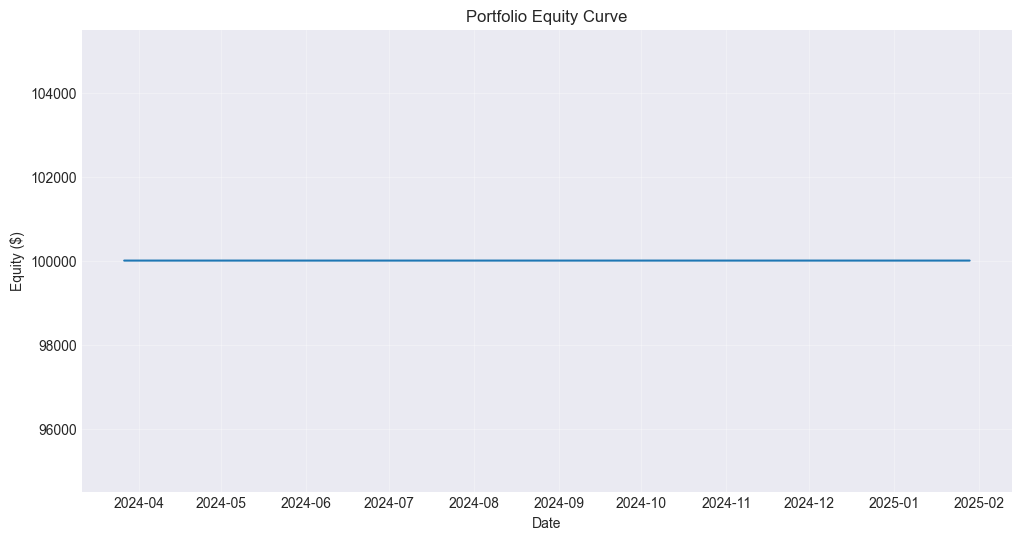

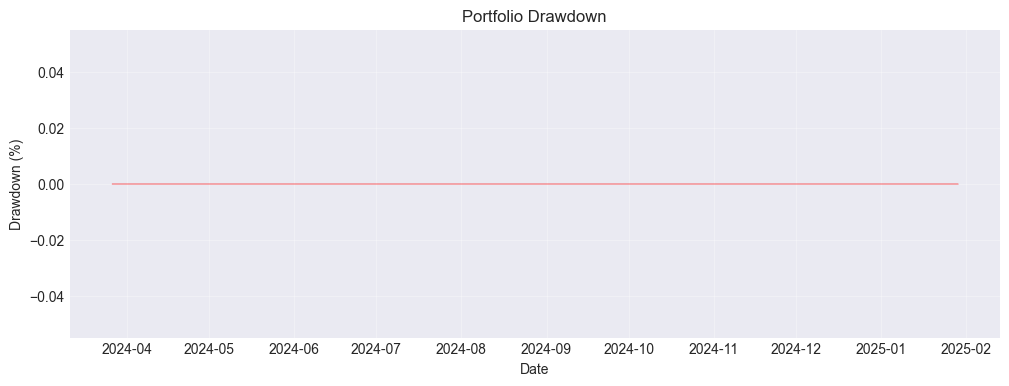

In [9]:
# Calculate overall performance metrics if we have trades
if len(trades_df) > 0:
    print("\n📈 PERFORMANCE METRICS")
    print("=" * 80)
    
    # Use PnL data if available
    if 'pnl' in trades_df:
        # Calculate equity curve from trades
        initial_capital = 100000  # Assumed
        trades_df = trades_df.sort_values('exit_time')
        trades_df['cum_pnl'] = trades_df['pnl'].cumsum()
        trades_df['equity'] = initial_capital + trades_df['cum_pnl']
        
        # Create equity curve dataframe
        equity_curve = []
        equity_curve.append({'timestamp': trades_df['entry_time'].min(), 'equity': initial_capital})
        for _, trade in trades_df.iterrows():
            equity_curve.append({'timestamp': trade['exit_time'], 'equity': trade['equity']})
        
        equity_df = pd.DataFrame(equity_curve)
        equity_df['returns'] = equity_df['equity'].pct_change()
        
        # Performance metrics
        total_return = (equity_df['equity'].iloc[-1] / initial_capital - 1)
        
        # Sharpe ratio (assuming daily returns)
        if 'exit_time' in trades_df and len(trades_df) > 1:
            daily_returns = trades_df.groupby(trades_df['exit_time'].dt.date)['pnl'].sum() / initial_capital
            if len(daily_returns) > 1 and daily_returns.std() > 0:
                sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)
            else:
                sharpe_ratio = 0
        else:
            sharpe_ratio = 0
        
        # Max drawdown
        cummax = equity_df['equity'].expanding().max()
        drawdown = (equity_df['equity'] / cummax - 1)
        max_drawdown = drawdown.min()
        
        # Win/loss statistics
        winning_trades = trades_df[trades_df['pnl'] > 0]
        losing_trades = trades_df[trades_df['pnl'] <= 0]
        
        print(f"Total Return: {total_return*100:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Max Drawdown: {max_drawdown*100:.2f}%")
        print(f"\nTrade Statistics:")
        print(f"  Total Trades: {len(trades_df)}")
        print(f"  Win Rate: {len(winning_trades)/len(trades_df)*100:.1f}%")
        print(f"  Average Win: ${winning_trades['pnl'].mean():.2f}" if len(winning_trades) > 0 else "  Average Win: N/A")
        print(f"  Average Loss: ${losing_trades['pnl'].mean():.2f}" if len(losing_trades) > 0 else "  Average Loss: N/A")
        
        if len(losing_trades) > 0 and losing_trades['pnl'].sum() != 0:
            profit_factor = winning_trades['pnl'].sum() / abs(losing_trades['pnl'].sum())
            print(f"  Profit Factor: {profit_factor:.2f}")
        else:
            print(f"  Profit Factor: N/A")
        
        # Performance vs thresholds
        print(f"\n🎯 Performance vs Thresholds:")
        print(f"  Sharpe Ratio: {sharpe_ratio:.2f} {'✅' if sharpe_ratio >= min_sharpe_ratio else '❌'} (min: {min_sharpe_ratio})")
        print(f"  Max Drawdown: {abs(max_drawdown)*100:.1f}% {'✅' if abs(max_drawdown) <= max_acceptable_drawdown else '❌'} (max: {max_acceptable_drawdown*100:.0f}%)")
        print(f"  Win Rate: {len(winning_trades)/len(trades_df)*100:.1f}% {'✅' if len(winning_trades)/len(trades_df) >= min_win_rate else '❌'} (min: {min_win_rate*100:.0f}%)")
        
        # Plot equity curve
        plt.figure(figsize=(12, 6))
        plt.plot(equity_df['timestamp'], equity_df['equity'])
        plt.title('Portfolio Equity Curve')
        plt.xlabel('Date')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Plot drawdown
        plt.figure(figsize=(12, 4))
        plt.fill_between(equity_df['timestamp'], drawdown * 100, 0, alpha=0.3, color='red')
        plt.title('Portfolio Drawdown')
        plt.xlabel('Date')
        plt.ylabel('Drawdown (%)')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("⚠️ No PnL data available in trades")
else:
    print("\n⚠️ No trades available for performance analysis")
    print("\nPossible reasons why no trades were executed:")
    print("1. Risk parameters (stop loss: 0.075%, take profit: 0.1%) may be too tight")
    print("2. Position sizing returned 0 shares")
    print("3. Intraday constraints prevented trades") 
    print("4. Signals were generated but didn't meet execution criteria")
    print("\nCheck the signal analysis section above to confirm signals were generated.")

## Intraday Pattern Analysis


⏰ INTRADAY PATTERN ANALYSIS


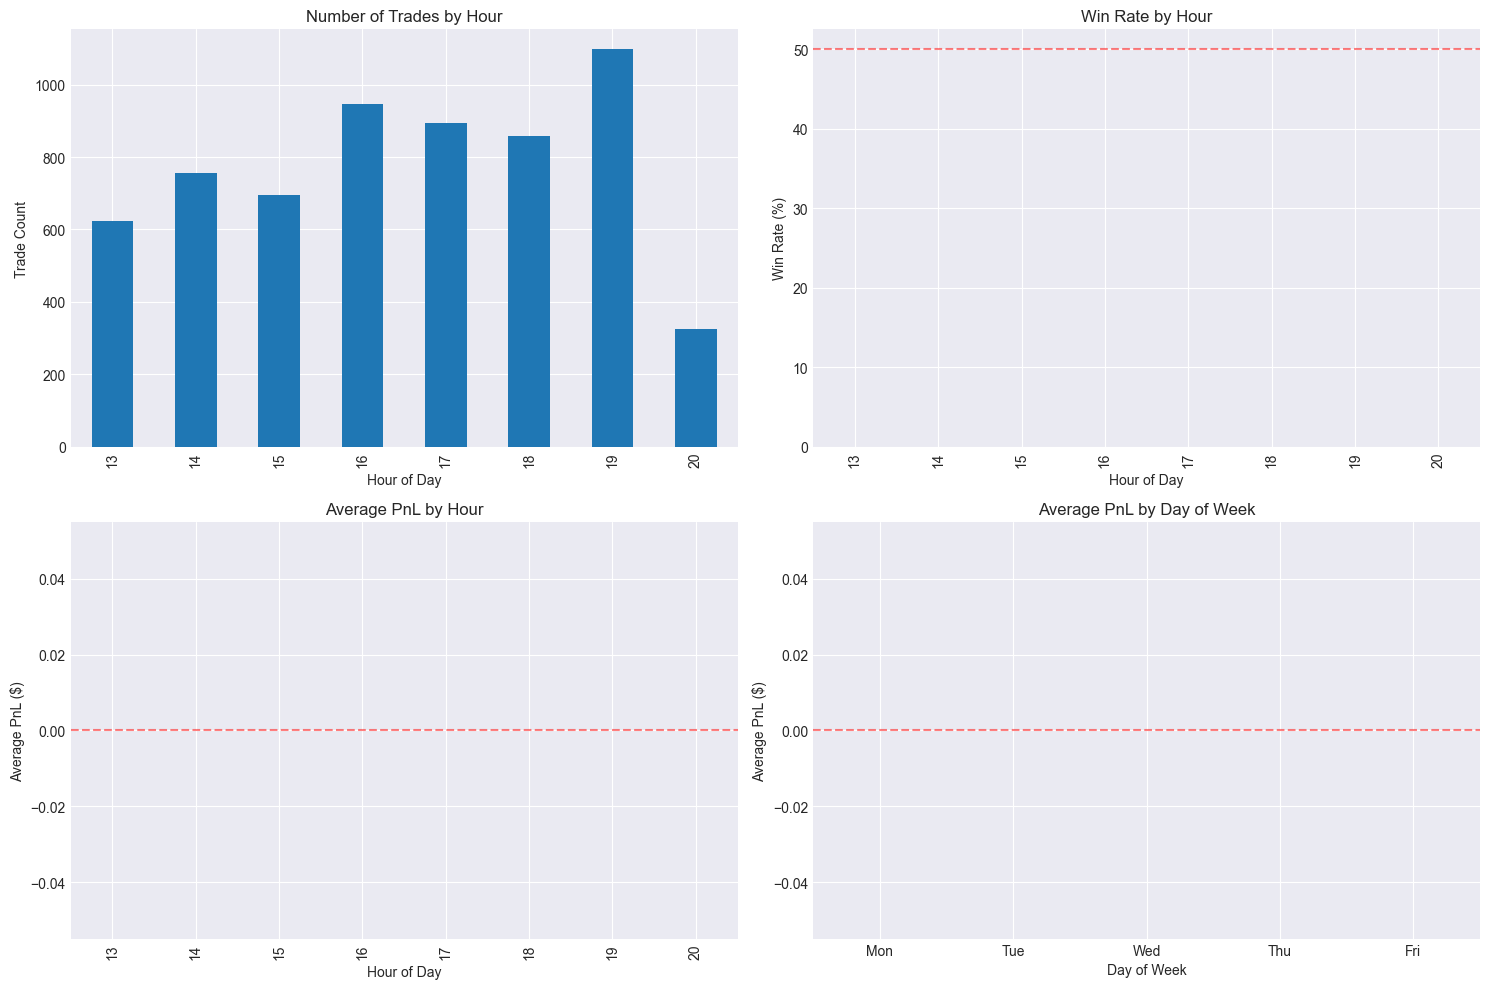


🕐 Best Trading Hours:
  13:00 - Avg PnL: $0.00, Win Rate: 0.0%, Trades: 624
  14:00 - Avg PnL: $0.00, Win Rate: 0.0%, Trades: 756
  15:00 - Avg PnL: $0.00, Win Rate: 0.0%, Trades: 696

🕐 Worst Trading Hours:
  13:00 - Avg PnL: $0.00, Win Rate: 0.0%, Trades: 624
  14:00 - Avg PnL: $0.00, Win Rate: 0.0%, Trades: 756
  15:00 - Avg PnL: $0.00, Win Rate: 0.0%, Trades: 696


In [10]:
# Analyze intraday patterns if requested
if analyze_intraday_patterns and len(trades_df) > 0:
    print("\n⏰ INTRADAY PATTERN ANALYSIS")
    print("=" * 80)
    
    # Extract hour of entry and exit
    trades_df['entry_hour'] = trades_df['entry_time'].dt.hour
    trades_df['exit_hour'] = trades_df['exit_time'].dt.hour
    trades_df['entry_day'] = trades_df['entry_time'].dt.dayofweek
    
    # Performance by hour of day
    hourly_performance = trades_df.groupby('entry_hour').agg({
        'pnl': ['count', 'sum', 'mean'],
        'return': 'mean'
    })
    
    # Win rate by hour
    hourly_win_rate = trades_df.groupby('entry_hour').apply(
        lambda x: (x['pnl'] > 0).mean() * 100
    )
    
    # Performance by day of week
    daily_performance = trades_df.groupby('entry_day').agg({
        'pnl': ['count', 'sum', 'mean'],
        'return': 'mean'
    })
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Trades by hour
    ax = axes[0, 0]
    hourly_performance['pnl']['count'].plot(kind='bar', ax=ax)
    ax.set_title('Number of Trades by Hour')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Trade Count')
    
    # Win rate by hour
    ax = axes[0, 1]
    hourly_win_rate.plot(kind='bar', ax=ax, color='green')
    ax.axhline(50, color='red', linestyle='--', alpha=0.5)
    ax.set_title('Win Rate by Hour')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Win Rate (%)')
    
    # Average PnL by hour
    ax = axes[1, 0]
    hourly_performance['pnl']['mean'].plot(kind='bar', ax=ax, color='blue')
    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_title('Average PnL by Hour')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average PnL ($)')
    
    # Performance by day of week
    ax = axes[1, 1]
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
    daily_performance['pnl']['mean'].plot(kind='bar', ax=ax, color='purple')
    ax.set_xticklabels(days[:len(daily_performance)], rotation=0)
    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_title('Average PnL by Day of Week')
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Average PnL ($)')
    
    plt.tight_layout()
    plt.show()
    
    # Best and worst times
    print("\n🕐 Best Trading Hours:")
    best_hours = hourly_performance['pnl']['mean'].nlargest(3)
    for hour, avg_pnl in best_hours.items():
        count = hourly_performance.loc[hour, ('pnl', 'count')]
        win_rate = hourly_win_rate.loc[hour]
        print(f"  {hour}:00 - Avg PnL: ${avg_pnl:.2f}, Win Rate: {win_rate:.1f}%, Trades: {count}")
    
    print("\n🕐 Worst Trading Hours:")
    worst_hours = hourly_performance['pnl']['mean'].nsmallest(3)
    for hour, avg_pnl in worst_hours.items():
        count = hourly_performance.loc[hour, ('pnl', 'count')]
        win_rate = hourly_win_rate.loc[hour]
        print(f"  {hour}:00 - Avg PnL: ${avg_pnl:.2f}, Win Rate: {win_rate:.1f}%, Trades: {count}")

## Risk Analysis


⚠️ RISK ANALYSIS
Trade Duration Statistics (in bars):
  Average: 1.1 bars
  Median: 1.0 bars
  Shortest: 1 bars
  Longest: 3 bars

Streak Analysis:
  Max consecutive wins: 0
  Max consecutive losses: 6198
  Average win streak: N/A
  Average loss streak: 6198.0

Value at Risk (VaR):
  95% VaR: $0.00
  99% VaR: $0.00


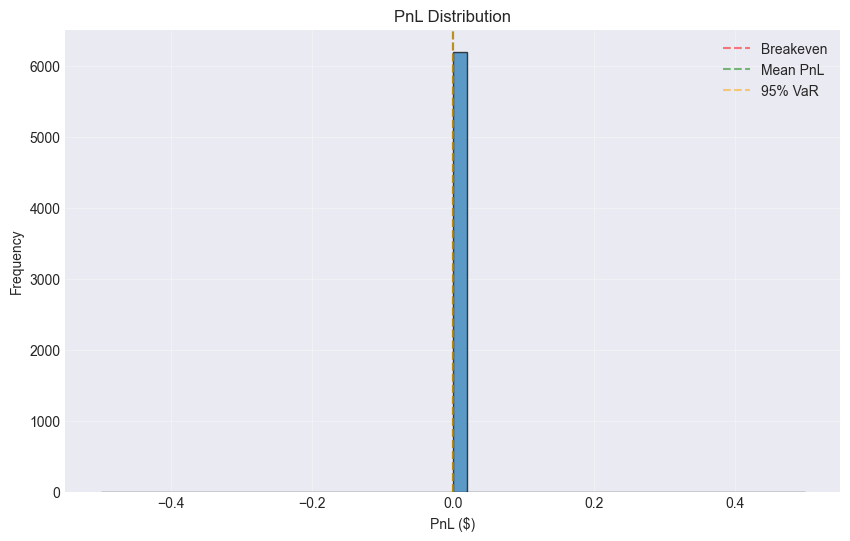


Available trade data columns: ['trade_id', 'position_id', 'symbol', 'strategy_id', 'signal_hash', 'entry_bar_idx', 'entry_time', 'entry_signal_strength', 'direction', 'entry_order_id', 'entry_order_price', 'entry_order_time', 'entry_fill_id', 'entry_fill_price', 'entry_fill_time', 'exit_bar_idx', 'exit_time', 'exit_reason', 'exit_signal_strength', 'pnl', 'duration_bars', 'exit_order_id', 'exit_order_price', 'exit_order_time', 'exit_fill_id', 'exit_fill_price', 'exit_fill_time', 'commission', 'slippage_entry', 'slippage_exit', 'duration_time', 'return', 'entry_time_to_fill', 'exit_time_to_fill', 'cum_pnl', 'equity', 'entry_hour', 'exit_hour', 'entry_day', 'is_win', 'streak']


In [11]:
# Comprehensive risk analysis
if len(trades_df) > 0:
    print("\n⚠️ RISK ANALYSIS")
    print("=" * 80)
    
    # Trade duration analysis
    if 'duration' in trades_df.columns:
        print("Trade Duration Statistics:")
        print(f"  Average: {trades_df['duration'].mean():.1f} minutes")
        print(f"  Median: {trades_df['duration'].median():.1f} minutes")
        print(f"  Shortest: {trades_df['duration'].min():.1f} minutes")
        print(f"  Longest: {trades_df['duration'].max():.1f} minutes")
    elif 'duration_bars' in trades_df.columns:
        print("Trade Duration Statistics (in bars):")
        print(f"  Average: {trades_df['duration_bars'].mean():.1f} bars")
        print(f"  Median: {trades_df['duration_bars'].median():.1f} bars")
        print(f"  Shortest: {trades_df['duration_bars'].min():.0f} bars")
        print(f"  Longest: {trades_df['duration_bars'].max():.0f} bars")
    elif 'duration_time' in trades_df.columns:
        print("Trade Duration Statistics:")
        print(f"  Duration times available in 'duration_time' column")
    
    # Consecutive wins/losses
    if 'pnl' in trades_df.columns:
        trades_df['is_win'] = trades_df['pnl'] > 0
        trades_df['streak'] = (trades_df['is_win'] != trades_df['is_win'].shift()).cumsum()
        
        win_streaks = trades_df[trades_df['is_win']].groupby('streak').size()
        loss_streaks = trades_df[~trades_df['is_win']].groupby('streak').size()
        
        print(f"\nStreak Analysis:")
        print(f"  Max consecutive wins: {win_streaks.max() if len(win_streaks) > 0 else 0}")
        print(f"  Max consecutive losses: {loss_streaks.max() if len(loss_streaks) > 0 else 0}")
        print(f"  Average win streak: {win_streaks.mean():.1f}" if len(win_streaks) > 0 else "  Average win streak: N/A")
        print(f"  Average loss streak: {loss_streaks.mean():.1f}" if len(loss_streaks) > 0 else "  Average loss streak: N/A")
    
    # Risk-adjusted returns
    if 'return' in trades_df.columns and trades_df['return'].std() > 0:
        information_ratio = trades_df['return'].mean() / trades_df['return'].std()
        print(f"\nRisk-Adjusted Metrics:")
        print(f"  Information Ratio: {information_ratio:.3f}")
        print(f"  Return/Risk: {trades_df['return'].mean() / trades_df['return'].std():.3f}")
    
    # Value at Risk (VaR)
    if 'pnl' in trades_df.columns:
        var_95 = np.percentile(trades_df['pnl'], 5)
        var_99 = np.percentile(trades_df['pnl'], 1)
        
        print(f"\nValue at Risk (VaR):")
        print(f"  95% VaR: ${var_95:.2f}")
        print(f"  99% VaR: ${var_99:.2f}")
        
        # Plot PnL distribution
        plt.figure(figsize=(10, 6))
        plt.hist(trades_df['pnl'], bins=50, alpha=0.7, edgecolor='black')
        plt.axvline(0, color='red', linestyle='--', alpha=0.5, label='Breakeven')
        plt.axvline(trades_df['pnl'].mean(), color='green', linestyle='--', alpha=0.5, label='Mean PnL')
        plt.axvline(var_95, color='orange', linestyle='--', alpha=0.5, label='95% VaR')
        plt.xlabel('PnL ($)')
        plt.ylabel('Frequency')
        plt.title('PnL Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Show what columns are available for further analysis
    print(f"\nAvailable trade data columns: {list(trades_df.columns)}")

## Summary and Recommendations

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
# Generate summary and recommendations
print("\n📋 SUMMARY AND RECOMMENDATIONS")
print("=" * 80)

summary = {
    'run_info': {
        'run_id': run_dir.name,
        'config_name': config_name,
        'analysis_timestamp': datetime.now().isoformat(),
        'is_full_system': is_full_system
    },
    'data_summary': {
        'total_bars': metadata.get('total_bars', 0),
        'total_signals': metadata.get('total_signals', 0),
        'total_orders': metadata.get('total_orders', 0),
        'total_fills': metadata.get('total_fills', 0),
        'total_positions': metadata.get('total_positions', 0)
    },
    'performance_summary': {},
    'risk_summary': {},
    'recommendations': []
}

if len(trades_df) > 0:
    # Performance summary
    summary['performance_summary'] = {
        'total_trades': len(trades_df),
        'total_return': float(total_return),
        'sharpe_ratio': float(sharpe_ratio),
        'max_drawdown': float(max_drawdown),
        'win_rate': float(len(winning_trades)/len(trades_df)),
        'profit_factor': float(winning_trades['pnl'].sum() / abs(losing_trades['pnl'].sum())) if len(losing_trades) > 0 and losing_trades['pnl'].sum() != 0 else 0
    }
    
    # Risk summary
    summary['risk_summary'] = {
        'var_95': float(var_95),
        'var_99': float(var_99),
        'max_consecutive_losses': int(loss_streaks.max()) if len(loss_streaks) > 0 else 0,
        'avg_trade_duration_minutes': float(trades_df['duration'].mean())
    }
    
    # Generate recommendations
    if sharpe_ratio < min_sharpe_ratio:
        summary['recommendations'].append({
            'type': 'performance',
            'severity': 'high',
            'message': f'Sharpe ratio ({sharpe_ratio:.2f}) below minimum threshold ({min_sharpe_ratio}). Consider parameter optimization.'
        })
    
    if abs(max_drawdown) > max_acceptable_drawdown:
        summary['recommendations'].append({
            'type': 'risk',
            'severity': 'high',
            'message': f'Maximum drawdown ({abs(max_drawdown)*100:.1f}%) exceeds acceptable limit ({max_acceptable_drawdown*100:.0f}%). Implement stricter risk controls.'
        })
    
    if len(winning_trades)/len(trades_df) < min_win_rate:
        summary['recommendations'].append({
            'type': 'performance',
            'severity': 'medium',
            'message': f'Win rate ({len(winning_trades)/len(trades_df)*100:.1f}%) below minimum ({min_win_rate*100:.0f}%). Review entry criteria.'
        })
    
    # Execution-specific recommendations
    if 'slippage_bps' in fills.columns and fills['slippage_bps'].mean() > 5:
        summary['recommendations'].append({
            'type': 'execution',
            'severity': 'medium',
            'message': f'High average slippage ({fills["slippage_bps"].mean():.1f} bps). Consider limit orders or better execution timing.'
        })
    
    # Intraday pattern recommendations
    if analyze_intraday_patterns and 'hourly_performance' in locals():
        worst_hour = hourly_performance['pnl']['mean'].idxmin()
        if hourly_performance.loc[worst_hour, ('pnl', 'mean')] < -50:
            summary['recommendations'].append({
                'type': 'timing',
                'severity': 'low',
                'message': f'Poor performance at {worst_hour}:00. Consider avoiding trades during this hour.'
            })

# Display recommendations
if summary['recommendations']:
    print("🎯 Recommendations:")
    for rec in sorted(summary['recommendations'], key=lambda x: {'high': 0, 'medium': 1, 'low': 2}[x['severity']]):
        severity_icon = {'high': '🔴', 'medium': '🟡', 'low': '🟢'}[rec['severity']]
        print(f"\n{severity_icon} [{rec['severity'].upper()}] {rec['type'].title()}")
        print(f"   {rec['message']}")
else:
    print("✅ No critical issues identified")

# Save summary
with open(run_dir / 'analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n📄 Analysis summary saved to: analysis_summary.json")


📋 SUMMARY AND RECOMMENDATIONS


KeyError: 'duration'

## Export Results

In [ ]:
# Export key dataframes for further analysis
print("\n💾 EXPORTING RESULTS")
print("=" * 80)

exports = {}

# Export trades if available
if len(trades_df) > 0:
    trades_export_path = run_dir / 'analyzed_trades.csv'
    trades_df.to_csv(trades_export_path, index=False)
    exports['trades'] = 'analyzed_trades.csv'
    print(f"✅ Exported {len(trades_df)} trades to {trades_export_path}")
    
    # Export performance summary
    if 'pnl' in trades_df:
        performance_summary = {
            'total_trades': len(trades_df),
            'total_pnl': trades_df['pnl'].sum(),
            'win_rate': (trades_df['pnl'] > 0).mean(),
            'avg_pnl': trades_df['pnl'].mean(),
            'best_trade': trades_df['pnl'].max(),
            'worst_trade': trades_df['pnl'].min(),
            'avg_duration_bars': trades_df['duration_bars'].mean() if 'duration_bars' in trades_df else None
        }
        
        perf_summary_path = run_dir / 'performance_summary.json'
        with open(perf_summary_path, 'w') as f:
            json.dump(performance_summary, f, indent=2)
        exports['performance_summary'] = 'performance_summary.json'
        print(f"✅ Exported performance summary")

# Export slippage analysis if available
if len(trades_df) > 0 and 'slippage_entry' in trades_df:
    slippage_summary = trades_df[['trade_id', 'symbol', 'entry_fill_price', 'exit_fill_price', 
                                  'slippage_entry', 'slippage_exit']].copy()
    slippage_path = run_dir / 'slippage_analysis.csv'
    slippage_summary.to_csv(slippage_path, index=False)
    exports['slippage'] = 'slippage_analysis.csv'
    print(f"✅ Exported slippage analysis")

# Export equity curve if calculated
if 'equity_df' in locals() and len(equity_df) > 0:
    equity_path = run_dir / 'equity_curve.csv'
    equity_df.to_csv(equity_path, index=False)
    exports['equity_curve'] = 'equity_curve.csv'
    print(f"✅ Exported equity curve")

# Create final report
report = {
    'analysis_complete': True,
    'timestamp': datetime.now().isoformat(),
    'exports': exports,
    'summary': summary,
    'global_store_used': use_global_store,
    'trades_file_location': str(store_path / 'T*.parquet') if use_global_store else None
}

final_report_path = run_dir / 'final_report.json'
with open(final_report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"\n✅ Analysis complete! Results saved to {run_dir}")

if use_global_store:
    print(f"\n📁 Note: Signal traces are in the global store at: {store_path}")
    print(f"   Trade data may be in: {store_path}/T*.parquet")